# torchkeras.KerasModel TensorBoard Demo

You can install torchkeras using pip:
`pip install torchkeras`

Here is a mnist cnn example using torchkeras.KerasModel  with visualization of tensorboad.


In [1]:
import sys 
sys.path.append("..")

In [2]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torchkeras #Attention this line 

### 1, prepare data 

In [3]:
import torchvision 
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor()])
ds_train = torchvision.datasets.MNIST(root="mnist/",train=True,download=True,transform=transform)
ds_val = torchvision.datasets.MNIST(root="mnist/",train=False,download=True,transform=transform)
dl_train =  torch.utils.data.DataLoader(ds_train, batch_size=128, shuffle=True, num_workers=2)
dl_val =  torch.utils.data.DataLoader(ds_val, batch_size=128, shuffle=False, num_workers=2)


In [4]:
for features,labels in dl_train:
    break
print(features.shape)
print(labels.shape)


torch.Size([128, 1, 28, 28])
torch.Size([128])


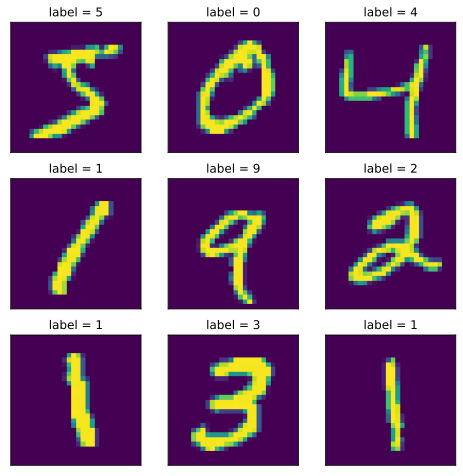

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_train[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

### 2, create the  model

In [6]:
def create_net():
    net = nn.Sequential()
    net.add_module("conv1",nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3))
    net.add_module("pool1",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("conv2",nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5))
    net.add_module("pool2",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("dropout",nn.Dropout2d(p = 0.1))
    net.add_module("adaptive_pool",nn.AdaptiveMaxPool2d((1,1)))
    net.add_module("flatten",nn.Flatten())
    net.add_module("linear1",nn.Linear(64,32))
    net.add_module("relu",nn.ReLU())
    net.add_module("linear2",nn.Linear(32,10))
    return net

net = create_net()

class Accuracy(nn.Module):
    def __init__(self):
        super().__init__()

        self.correct = nn.Parameter(torch.tensor(0.0),requires_grad=False)
        self.total = nn.Parameter(torch.tensor(0.0),requires_grad=False)

    def forward(self, preds: torch.Tensor, targets: torch.Tensor):
        preds = preds.argmax(dim=-1)
        m = (preds == targets).sum()
        n = targets.shape[0] 
        self.correct += m 
        self.total += n
        
        return m/n

    def compute(self):
        return self.correct.float() / self.total 
    
    def reset(self):
        self.correct -= self.correct
        self.total -= self.total
        

In [7]:
model = torchkeras.KerasModel(net,
      loss_fn = nn.CrossEntropyLoss(),
      optimizer= torch.optim.Adam(net.parameters(),lr=0.001),
      metrics_dict = {"acc":Accuracy()}
    )

from torchkeras import summary
summary(model,input_data=features);


--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Conv2d-1                            [-1, 32, 26, 26]                  320
MaxPool2d-2                         [-1, 32, 13, 13]                    0
Conv2d-3                              [-1, 64, 9, 9]               51,264
MaxPool2d-4                           [-1, 64, 4, 4]                    0
Dropout2d-5                           [-1, 64, 4, 4]                    0
AdaptiveMaxPool2d-6                   [-1, 64, 1, 1]                    0
Flatten-7                                   [-1, 64]                    0
Linear-8                                    [-1, 32]                2,080
ReLU-9                                      [-1, 32]                    0
Linear-10                                   [-1, 10]                  330
Total params: 53,994
Trainable params: 53,994
Non-trainable params: 0
-----------------------------------------

### 3, train the model

<<<<<< 🚀 mps is used >>>>>>


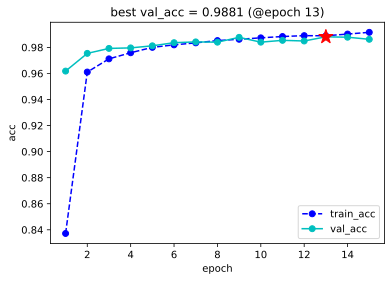

In [8]:
# you can also try: from torchkeras.kerascallbacks import WandbCallback
from torchkeras.kerascallbacks import TensorBoardCallback
dfhistory=model.fit(train_data=dl_train, 
                    val_data=dl_val, 
                    epochs=15, 
                    patience=5, 
                    monitor="val_acc",mode="max",
                    ckpt_path='checkpoint.pt',
                    callbacks = [TensorBoardCallback(save_dir='runs',
                                model_name='mnist_cnn',log_weight=True,log_weight_freq=5)]
                   )



In [ ]:
# visual the  prediction
device = None
for p in model.parameters():
    device = p.device
    break

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_train[i]
    tensor = img.to(device)
    y_pred = torch.argmax(net(tensor[None,...])) 
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("y_pred = %d"%y_pred)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()    

### 4, Monitor from TensorBoard

The TensorBoardCallback  saves logs at the directory  'runs'.

We can monitor and analysis training process using TensorBoard now.



!tensorboard --logdir="./runs" --bind_all --port=6006

In [9]:
from tensorboard import notebook
notebook.list() 
notebook.start("--logdir ./runs")

Known TensorBoard instances:
  - port 6006: logdir ./runs (started 1:05:47 ago; pid 96887)


Reusing TensorBoard on port 6006 (pid 96887), started 1:05:47 ago. (Use '!kill 96887' to kill it.)

![](./data/tb_acc.png)

![](./data/conv_weight.png)